In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import spacy
import random
from sklearn.utils import shuffle
from spacy.pipeline import TextCategorizer
from spacy.util import minibatch, compounding
from spacy.lang.en.stop_words import STOP_WORDS

In [0]:
# !python -m spacy download en_core_web_md
model = spacy.load("en_core_web_sm")

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
drug_train_full = pd.read_csv('/content/gdrive/My Drive/Data/kuc-hackathon-winter-2018/drugsComTrain_raw.csv')
drug_test_full = pd.read_csv('/content/gdrive/My Drive/Data/kuc-hackathon-winter-2018/drugsComTest_raw.csv')
drug_train_full.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [7]:
drug_train_full.condition.value_counts()

Birth Control                                   28788
Depression                                       9069
Pain                                             6145
Anxiety                                          5904
Acne                                             5588
                                                ...  
34</span> users found this comment helpful.         1
62</span> users found this comment helpful.         1
Postoperative Increased Intraocular Pressure        1
Infectious Diarrhea                                 1
121</span> users found this comment helpful.        1
Name: condition, Length: 884, dtype: int64

In [8]:
drug_test_full.condition.value_counts()

Birth Control                  9648
Depression                     3095
Pain                           2100
Anxiety                        1908
Acne                           1847
                               ... 
Gender Dysphoria                  1
Cerebral Edema                    1
Aspergillosis, Aspergilloma       1
Dermatomyositis                   1
Cyclitis                          1
Name: condition, Length: 708, dtype: int64

* Columns of interest: `review` and `condition`
* Distribution of `Condition` (class) is uneven
* As seen above, the *dataset is imbalanced*
* We'll therefore consider classifying only the top 5 categories:
    1. `Birth Control`
    2. `Depression`
    3. `Pain`
    4. `Anxiety`
    5. `Acne`
    

In [0]:
def create_subset(data, classes_list, colname, subset_cols=None):
    data = data.loc[data[colname].isin(classes_list)].copy()
    if subset_cols:
        return data[subset_cols]
    return data


In [0]:
cls_list = ['Birth Control', 'Depression', 'Pain', 'Anxiety', 'Acne']

drug_train = create_subset(drug_train_full, cls_list, 'condition', subset_cols=['condition', 'review'])
drug_test = create_subset(drug_test_full, cls_list, 'condition', subset_cols=['condition', 'review'])

In [11]:
print("Full shape:{train}{test}".format(train=drug_train_full.shape, test=drug_test_full.shape))
print("Shape:{train}{test}".format(train=drug_train.shape, test=drug_test.shape))

# shuffling the data
drug_train = shuffle(drug_train)
drug_train.reset_index(inplace=True, drop=True)

Full shape:(161297, 7)(53766, 7)
Shape:(55494, 2)(18598, 2)


**Data cleaning**
- Basic data preprocessing is done here
    - Lower case conversion
    - Stop word removal
    - Punctuation removal
- Room for improvement - *incomplete*

In [12]:
punctuations = string.punctuation
foreign_chars =  ['“','”', '"', '"']

stopwords = list(STOP_WORDS) + foreign_chars

def spacy_cleanup(df,col):
    df[col] = df[col].apply(lambda x: " ".join([token.lower() for token in str(x).split()
                                                if token not in stopwords and token not in punctuations]))
    return df

train = spacy_cleanup(drug_train.copy(), 'review')
train.head()

,condition,review
0,Birth Control,"""i miscarriage went obgyn prescribed lolo. he ..."
1,Birth Control,"""i got nexplanon bout 5 mouths ago works good ..."
2,Birth Control,"""i&#039;ve levora 3 months finally coming read..."
3,Anxiety,"""awful drug. i year straight i comprehend anyt..."
4,Depression,"""i taking 15mg night mirtazapine month. i know..."


##### Text Categorizer
- Is added as a spacy pipeline component (with configurations)
- Requires data to be prepared in a specific way. See `prepare_data` function

In [0]:
"""
The training annotations (labels) have to be encoded as shown in the below dictionary.
This is then fed to SpaCY's Text Categorizer for training.
"""

data_dict = {}
for c in cls_list:
    data_dict[c] = False
    
"""
Text Categorizer is a component in the Language Model pipeline.
A basic, pipeline consists of `tokenizer`, `ner`, `dependency parser` to which we include the `textcat` here.

The architecture could be any one of 

"bow" (Bag-of-words)
"simple_cnn" (A basic CNN)
"ensemble" (Ensemble of BOW + CNN) -- most powerful!

More info:

https://spacy.io/usage/training#textcat
https://spacy.io/api/textcategorizer
"""
textcat = model.create_pipe("textcat", config={"exclusive_classes": True, "architecture": "simple_cnn"})
model.add_pipe(textcat, last=True)

for label in train.condition.unique():
    textcat.add_label(label)

##### Data preparation for multi-class

- The category/label against each text(`X`) should be a dictionary
- Each text would have a corresponding dictionary of categories (as keys)
- The actual label(`y`) for a text is identified by the category that's set to `True`

In [0]:
def prepare_data(texts, labels, default_dict, split=None):
    
    cats = []
    
    for label in labels:
        if label in default_dict:
            default_dict[label]=True
        new_dict = dict(default_dict)
        cats.append(new_dict)
        default_dict[label] = False
    if split is None:
        return (texts, cats)
    split = int(len(texts) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

In [15]:
texts = list(train['review'])
labels = list(train['condition'])

(train_texts, train_cats), (val_texts, val_cats) = prepare_data(texts, labels, data_dict, split=0.8)   

print("Training set size: {}, validation set size: {}".format(len(train_texts), len(val_texts)))

train_data = list(zip(train_texts, [{"cats": cats} for cats in train_cats]))
val_data = list(zip(val_texts, [{"cats": cats} for cats in val_cats]))

Training set size: 44395, validation set size: 11099


In [0]:
def simple_eval(model, val_texts, val_cats):
    score = 0
    for X,y in zip(val_texts, val_cats):
        
        pred = model(X)
        y_pred = max(pred.cats, key=pred.cats.get)
        if y['cats'][y_pred] == True:
            score +=1
        
    return np.float32(score / len(val_texts))


Training the model...
Iter #0		Training Loss: 14.084883855412954	Training Acc: 0.95652174949646
Iter #1		Training Loss: 0.16096213638502377	Training Acc: 0.9090909361839294
Iter #2		Training Loss: 0.13926268653131046	Training Acc: 1.0
Iter #3		Training Loss: 0.12574984532619737	Training Acc: 0.9090909361839294
Iter #4		Training Loss: 0.11119573119708548	Training Acc: 0.9090909361839294
Iter #5		Training Loss: 0.1028192067260818	Training Acc: 0.9090909361839294
Iter #6		Training Loss: 0.08814596283984244	Training Acc: 1.0
Iter #7		Training Loss: 0.08183947423086124	Training Acc: 0.9090909361839294
Iter #8		Training Loss: 0.07308641837910557	Training Acc: 1.0
Iter #9		Training Loss: 0.06776234113414503	Training Acc: 1.0


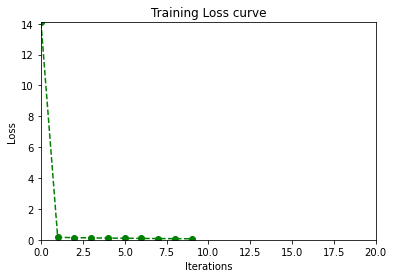

In [17]:
N_ITER = 10

pipe_exceptions = ["textcat"]
other_pipes = [pipe for pipe in model.pipe_names if pipe not in pipe_exceptions]


with(model.disable_pipes(*other_pipes)):
    optimizer = model.begin_training()
    
    print("Training the model...")
    
    batch_sizes = compounding(4.0, 32.0, 1.001)
    all_losses = []
    for i in range(N_ITER):
        
        losses = {}
        random.shuffle(train_data)
        batches = minibatch(train_data, size=batch_sizes)
        
        for batch in batches:
            texts, annotations = zip(*batch)
            model.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
            acc = simple_eval(model, texts, annotations)

        print("Iter #{}\t\tTraining Loss: {}\tTraining Acc: {}".format(i, losses['textcat'], acc))    
        all_losses.append(losses['textcat'])
    
    plt.title('Training Loss curve')
    plt.plot(range(0,N_ITER), all_losses, 'go--')
    plt.xlim((0,20))
    plt.ylim((0,max(all_losses)))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

        

In [18]:
val_texts, val_cats = zip(*val_data)

score = simple_eval(model, val_texts, val_cats)
print("Evaluation accuracy on validation set: {} %".format(round(score * 100,2)))

Evaluation accuracy on validation set: 93.95 %


**Let's see how the Precision/Recall/F-scores are for Training data itself**

In [19]:
# using the built-in model scoring function
scorer = model.evaluate(train_data, verbose=False)
print("Score:{}".format(scorer.scores['textcat_score']))

scores_per_cat = pd.DataFrame(scorer.scores['textcats_per_cat']).transpose()
scores_per_cat.columns = ['Precision', 'Recall', 'F-Score']
scores_per_cat.head(5)

Score:97.97182746945896


,Precision,Recall,F-Score
Birth Control,99.390929,99.830788,99.610373
Anxiety,95.225131,96.559779,95.887811
Depression,97.499655,97.257820,97.378587
Pain,99.042770,98.861557,98.952081
Acne,99.629715,96.481398,98.030286


- Above metrics suggest possible overfitting
- The present test dataset is insufficient to establish this argument though

##### Here's some independent test data

In [20]:
drug_test.head()

,condition,review
0,Depression,"""I&#039;ve tried a few antidepressants over th..."
4,Birth Control,"""I have been on this birth control for one cyc..."
6,Birth Control,"""I&#039;ve had the copper coil for about 3 mon..."
9,Birth Control,"""I was on this pill for almost two years. It d..."
17,Acne,"""So I was on Ginanvi for about 3 months before..."


In [21]:
test = spacy_cleanup(drug_test.copy(), 'review')

test_texts = list(test['review'])
test_labels = list(test['condition'])

(test_texts, test_cats) = prepare_data(test_texts, test_labels, data_dict)
test_data = list(zip(test_texts, [{"cats": cats} for cats in test_cats]))

# using the built-in model scoring function
scorer = model.evaluate(test_data, verbose=False)
print("Test score:{}".format(scorer.scores['textcat_score']))

scores_per_cat = pd.DataFrame(scorer.scores['textcats_per_cat']).transpose()
scores_per_cat.columns = ['Precision', 'Recall', 'F-Score']
scores_per_cat.head(5)

Test score:91.19535996359043


,Precision,Recall,F-Score
Birth Control,98.236386,98.725124,98.480149
Anxiety,81.780105,81.865828,81.822944
Depression,87.744000,88.594507,88.167203
Pain,93.717525,94.476190,94.095328
Acne,96.000000,90.958311,93.411176
